# Прогнозирование заказов такси

**Задача:** Обучить модель предсказывать количество заказов такси на следующий час.

Метрика RMSE

**План проекта:**

1. Общая информация
2. Анализа данных
    - заказы такси за месяц
    - заказы такси за неделю
    - заказы такси за 3 дня
3. Обучение модели
4. Тестирование

## Общая информация

In [1]:
# библиотеки
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
pth1 = 'https://datasets/taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('sth is wrong')

In [3]:
# откроем файл
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
# проверим монотонность
df.index.is_monotonic

True

In [7]:
# изменение интервала
df = df.resample('1H').sum()

In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Вывод:** В нашем распоряжении данные заказов такси за период с 1 марта по 31 августа 2018 года. В данных нет пропусков, они расположены в хронологическом порядке с интервалом в 10 минут. Сделали ресемплирование по часу.

## Анализ

Изучим как изменяются со временим количество заказов в сервисе такси. Проанализируем ряды, найдем тренд и сезонность. Рассмотрим данные в масштабе месяца, недели и трех дней. 

In [10]:
# для графиков
def charts1(data):
    decomposed = seasonal_decompose(data)
    plt.figure(figsize=(12, 10))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()

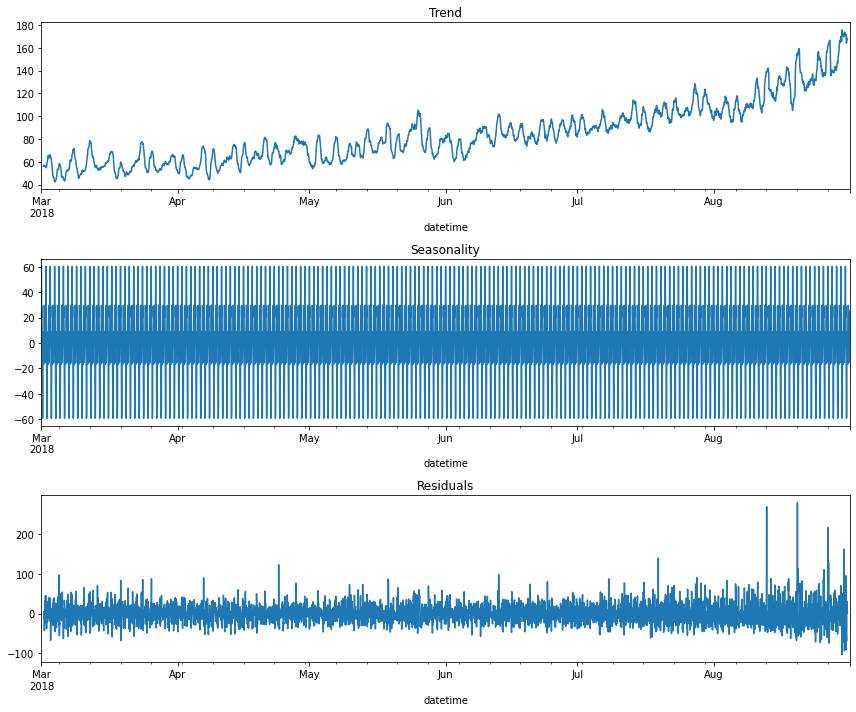

In [11]:
charts1(df)

### Месяц

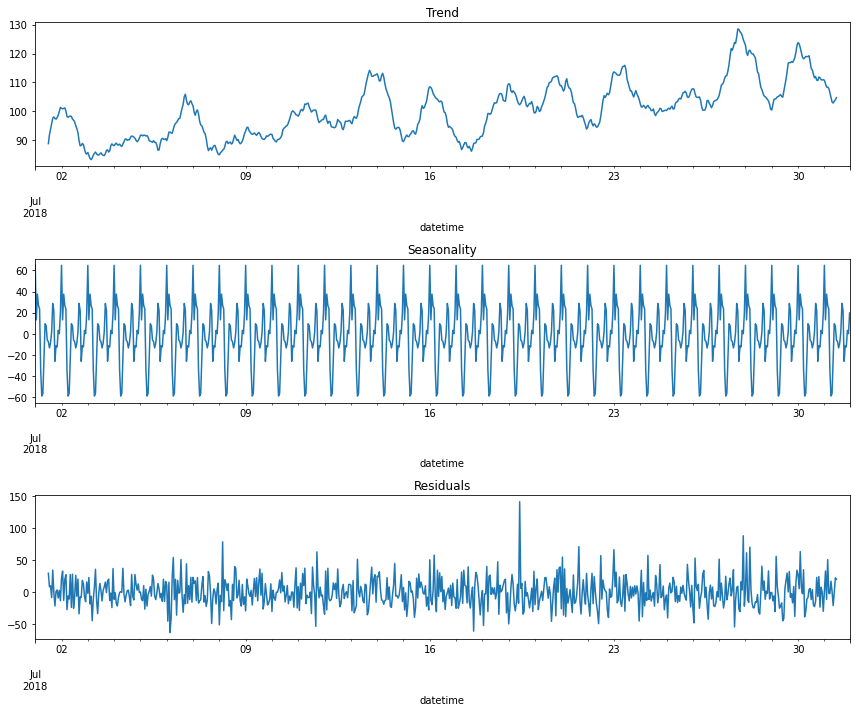

In [12]:
charts1(df['2018-07-01':'2018-07-31'])

### Неделя

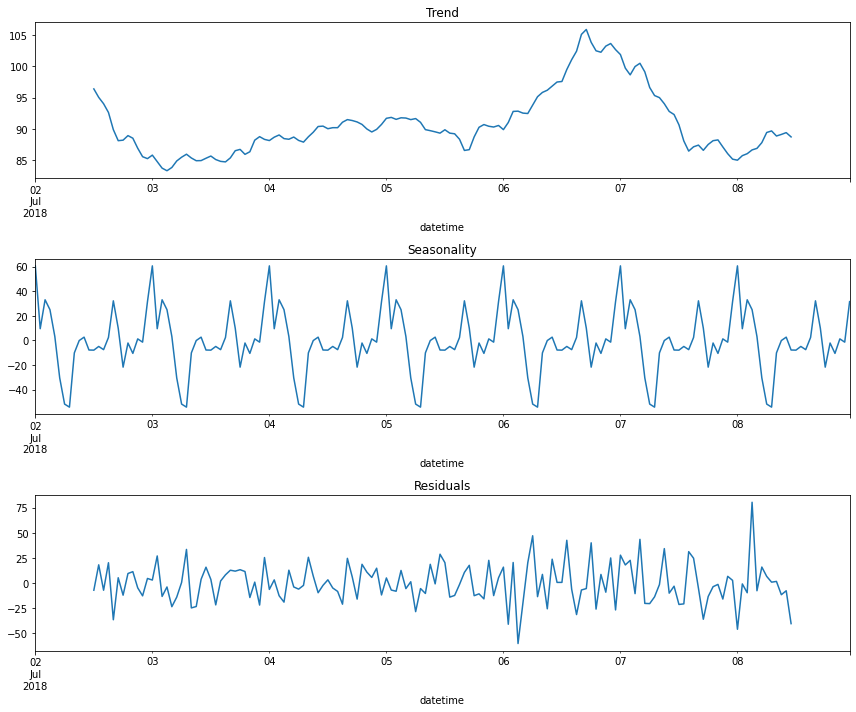

In [13]:
charts1(df['2018-07-02':'2018-07-08'])

### Три дня

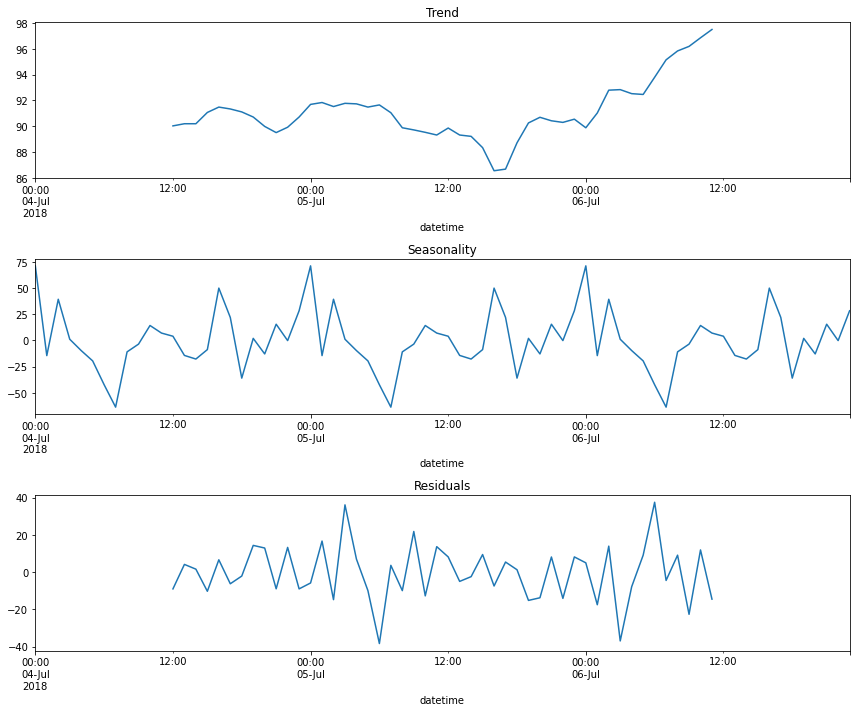

In [14]:
charts1(df['2018-07-04':'2018-07-06'])

**Вывод:** По линии тренда видно, что количество заказов такси к концу лета выросло посравнению с началом весны примерно в три раза. Есть суточная сезонность. К концу дня больше всего заказов. Под утро происходит резкий спад. Также число заказов возрастает ближе к выходным. 

## Обучение

Создадим признаки. Разделим данные на две выборки. Обучим модели градиентного бустинга, линейной регрессии, случайного леса.

### Признаки

In [15]:
# функция для создания новых признаков
def make_features(data, max_lag, rolling_mean_size):
    df_new = data.copy()
    
    #df_new['year'] = df_new.index.year
    df_new['month'] = df_new.index.month
    #df_new['day'] = df_new.index.day
    df_new['dayofweek'] = df_new.index.dayofweek

    for lag in range(1, max_lag + 1):
        df_new['lag_{}'.format(lag)] = df_new['num_orders'].shift(lag)

    df_new['rolling_mean'] = (df_new['num_orders'].shift()
                            .rolling(rolling_mean_size)
                            .mean())
    
    return df_new

In [16]:
# создадим новые признаки
df_new = make_features(df, 24, 24*7)
df_new.head(10)

,num_orders,month,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,3,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,3,6.0,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,3,12.0,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,3,3,15.0,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# удалим пропуски
df_new.dropna(inplace=True)
df_new.head()

,num_orders,month,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,3,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,54.226190
2018-03-08 01:00:00,78,3,3,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,54.339286
2018-03-08 02:00:00,65,3,3,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,54.297619
2018-03-08 03:00:00,68,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,54.261905
2018-03-08 04:00:00,60,3,3,68.0,65.0,78.0,143.0,94.0,127.0,108.0,...,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,54.273810


In [18]:
print('Процент удаленных данных: {:,.2%}'
      .format((len(df) - len(df_new) )/ len(df)))

Процент удаленных данных: 3.80%


In [19]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4248 entries, 2018-03-08 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4248 non-null   int64  
 1   month         4248 non-null   int64  
 2   dayofweek     4248 non-null   int64  
 3   lag_1         4248 non-null   float64
 4   lag_2         4248 non-null   float64
 5   lag_3         4248 non-null   float64
 6   lag_4         4248 non-null   float64
 7   lag_5         4248 non-null   float64
 8   lag_6         4248 non-null   float64
 9   lag_7         4248 non-null   float64
 10  lag_8         4248 non-null   float64
 11  lag_9         4248 non-null   float64
 12  lag_10        4248 non-null   float64
 13  lag_11        4248 non-null   float64
 14  lag_12        4248 non-null   float64
 15  lag_13        4248 non-null   float64
 16  lag_14        4248 non-null   float64
 17  lag_15        4248 non-null

### Выборки

In [20]:
# выделим признаки
features = df_new.drop(['num_orders'], axis=1)
target = df_new['num_orders']

In [21]:
# разобьем выборку на тренировочную и тестовую
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1, random_state=12345)

print('Размер обучающей выборки:', target_train.shape[0], features_train.shape)
print('Размер тестовой выборки:', target_test.shape[0], features_test.shape)

Размер обучающей выборки: 3823 (3823, 27)
Размер тестовой выборки: 425 (425, 27)


In [22]:
# проверим корректность деления
print(features_train.index.min(), features_train.index.max())
print(features_test.index.min(), features_test.index.max())

2018-03-08 00:00:00 2018-08-14 06:00:00
2018-08-14 07:00:00 2018-08-31 23:00:00


### Модели

In [23]:
splits = TimeSeriesSplit(n_splits=5)

In [24]:
%%time
lgb_params = {'n_estimators': [20, 50, 100],
              'max_depth': [6, 8, 10], 
             }

lgb_model = LGBMRegressor()
lgb_grid_search = GridSearchCV(lgb_model, lgb_params,
                               cv=splits, scoring='neg_root_mean_squared_error')
lgb_grid_search.fit(features_train, target_train)
lgb_grid_search.best_params_

CPU times: user 4min 32s, sys: 3.04 s, total: 4min 35s
Wall time: 4min 35s


{'max_depth': 10, 'n_estimators': 50}

In [25]:
lgb_score = -lgb_grid_search.best_score_
print('Лучшее значение RMSE :', lgb_score)

Лучшее значение RMSE : 25.77094688578159


In [26]:
%%time
cb_params = {'depth': [6, 10],
             'learning_rate': [0.03, 0.1]
            }

cb_model = CatBoostRegressor()
cb_grid_search = GridSearchCV(cb_model, cb_params, cv=splits, 
                              scoring='neg_root_mean_squared_error')
cb_grid_search.fit(features_train, target_train)
cb_grid_search.best_params_

0:	learn: 29.1168216	total: 50.5ms	remaining: 50.5s
1:	learn: 28.7474684	total: 53.9ms	remaining: 26.9s
2:	learn: 28.4060588	total: 57.3ms	remaining: 19.1s
3:	learn: 28.1107441	total: 60.4ms	remaining: 15s
4:	learn: 27.7994051	total: 63.8ms	remaining: 12.7s
5:	learn: 27.4360805	total: 67ms	remaining: 11.1s
6:	learn: 27.1539565	total: 70.2ms	remaining: 9.96s
7:	learn: 26.8548988	total: 73.5ms	remaining: 9.11s
8:	learn: 26.6084170	total: 76.5ms	remaining: 8.42s
9:	learn: 26.3226165	total: 79.6ms	remaining: 7.88s
10:	learn: 26.0430333	total: 82.5ms	remaining: 7.42s
11:	learn: 25.7567937	total: 85.6ms	remaining: 7.04s
12:	learn: 25.5091723	total: 88.5ms	remaining: 6.72s
13:	learn: 25.2535967	total: 92.4ms	remaining: 6.51s
14:	learn: 25.0054388	total: 95.5ms	remaining: 6.27s
15:	learn: 24.7885776	total: 98.6ms	remaining: 6.07s
16:	learn: 24.5450104	total: 102ms	remaining: 5.89s
17:	learn: 24.2931782	total: 105ms	remaining: 5.72s
18:	learn: 24.0750692	total: 108ms	remaining: 5.56s
19:	learn:

{'depth': 6, 'learning_rate': 0.03}

In [27]:
cb_score = -cb_grid_search.best_score_
print('Лучшее значение RMSE :', cb_score)

Лучшее значение RMSE : 25.225654424459215


In [28]:
%%time
rf_params = {'max_depth' : [6, 12], 
             'n_estimators': [100, 150]
            }

rf_model = RandomForestRegressor()
rf_grid_search = GridSearchCV(rf_model, rf_params, cv=splits, 
                              scoring='neg_root_mean_squared_error')
rf_grid_search.fit(features_train, target_train)
rf_grid_search.best_params_

CPU times: user 47.1 s, sys: 135 ms, total: 47.2 s
Wall time: 47.4 s


{'max_depth': 12, 'n_estimators': 150}

In [29]:
rf_score = -rf_grid_search.best_score_
print('Лучшее значение RMSE :', rf_score)

Лучшее значение RMSE : 26.01932009477911


In [30]:
%%time
lr_model = LinearRegression()
lr_params = {}
lr_grid_search = GridSearchCV(lr_model, lr_params, cv=splits, 
                              scoring='neg_root_mean_squared_error')
lr_grid_search.fit(features_train, target_train)
lr_grid_search.best_params_

CPU times: user 263 ms, sys: 537 ms, total: 800 ms
Wall time: 744 ms


{}

In [31]:
lr_score = -lr_grid_search.best_score_
print('Лучшее значение RMSE :', lr_score)

Лучшее значение RMSE : 27.509939036757565


In [32]:
# итоговые метрики
results = pd.DataFrame({'Модель':['LightGBM', 'CatBoost', 'RandomForest', 'LinearRegression'],
                        'RMSE':[lgb_score, cb_score, rf_score, lr_score]
                       })

results.sort_values('RMSE')

,Модель,RMSE
1,CatBoost,25.225654
0,LightGBM,25.770947
2,RandomForest,26.019320
3,LinearRegression,27.509939


**Вывод:** Лучшее качество у модели CatBoost. Модель проигрывает по времени обучения LightGBM, качество которой чуть хуже.

## Тестирование

In [33]:
%%time
test_pred = cb_grid_search.best_estimator_.predict(features_test)
test_rmse = mean_squared_error(target_test, test_pred)**0.5
print('RMSE тестовой выборки', test_rmse)

RMSE тестовой выборки 41.44781614545705
CPU times: user 3.2 ms, sys: 3.93 ms, total: 7.13 ms
Wall time: 5.84 ms


Предсказания на тестовой выборке хуже, чем на обучающей. Однако показатели подходят под условие заказчика.

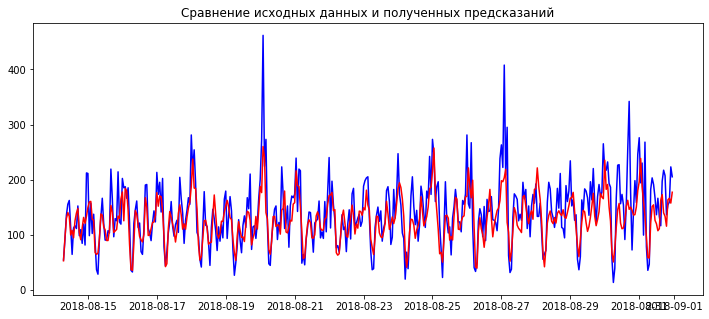

In [34]:
plt.figure(figsize=(12, 5))
plt.plot(features_test.index, target_test,
         'b-',
         features_test.index, pd.Series(test_pred),
         'r-'
        )
plt.title('Сравнение исходных данных и полученных предсказаний');

## Итоговый вывод

* Нам предоставлены данные за полгода (с 01.03.2018 по 31.08.2018), пропусков нет, расположены в хронологическом порядке. Поменяли интервал у данных с 10 минут на 1 час.
* Данные проанализированы. Рассмотрены тренд и сезонность за весь отрезок времени, за месяц (июль), за неделю и три дня. Есть тренд увеличения количества заказов такси к концу периода практически в три раза. Выявлена суточная сезонность. Большая часть заказов происходит вечером и сходит на нет под утро, также ближе к выходным количество заказов увеличивается.
* Были созданы признаки для обучения моделей. Данные разделены на две выборки: обучающую и тестовую в соотношении 10:1.
* Обучены модели LightGBM, CatBoost, RandomForest, LinearRegression. Подобранны гипперпараметры. Найден лучший RMSE. Выбрана модель CatBoost с качеством 25.2
* Лучшая модель протестирована/ Результат проверки показал качество хуже, чем на обучающей выборке, но оно удовлетворяет условию заказчика.